# Policy Document Creation Workflow

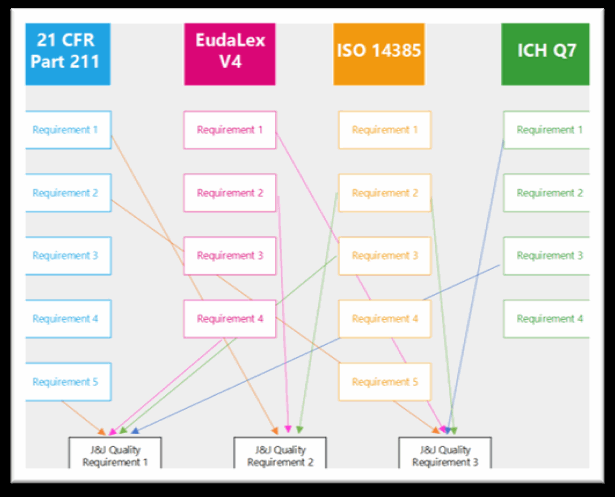

# Data Sets Used

- EU EudraLex V4 / Part I / Chapter 4 Documentation (PDF format)
- 32 regulatory requirements from EU EudraLex V4 / Part I / Chapter 4 Documentation (parsed from PDF => XML => extracted fields via XPATH)
- 74 regulatory requirements classified as "Personal Hygiene and Sanitation" (positive examples)
- 850 regulatory requirements classified as "other" (negative examples)

## Four Step Process

Step 1: Extract Requirements from Regulations (unstructured text into structured text / not part of OpenAI / see <a href="https://www.acodis.io/">Acodis</a>)<BR>
    <i><b>Step 2: Map Requirements to Quality Topic (supervised learning / classification)</b></i><BR>
    <i><b>Step 3: Group Quality Topic Requirements into Themes (unsupervised learning / clustering)</b></i><BR>
    <i><b>Step 4: Summarize Requirements from Quality Topic Theme (text summarization)</b></i>

## Purpose - given a regulation text:
#### 1. Categorize each text into the proper quality topic using OpenAI <i>fine-tuned model</i> (supervised)
#### 2. Cluster regulation text based on natural groupings using OpenAI <i>embeddings</i> (unsupervised)
#### 3. Based on natural groupings, create summary policy text using OpenAI GPT-3 <i>completions</i>

### Import necessary libraries, kick off the fine-tune job, and read in the test set used for validation

In [11]:

# import necessary libraries
import os
import logging
from pathlib import Path
import pickle
from time import sleep
from typing import List

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import openai
from openai.embeddings_utils import (
    get_embedding,
    distances_from_embeddings,
    tsne_components_from_embeddings,
    pca_components_from_embeddings,
    chart_from_components,
    indices_of_nearest_neighbors_from_distances,
    chart_from_components_3D
)

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

PARENT_PATH = Path(os.getcwd()).parent.absolute()
openai.api_key = os.getenv("OPENAI_API_KEY_BETA")

FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [12]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

**NOTE:** You may skip the section related to fine-tuning as it will exceed your OpenAI free tier credit, we will provide access to fine tuned model at a later stage.

I commented the cells related to fine tuning but kept the output so you can follow the process.

Before kicking off the fine-tune job, use this to prepare and upload the training dataset for fine-tuning: https://beta.openai.com/docs/guides/fine-tuning/cli-data-preparation-tool

In [3]:
# check for training file
#openai.File.list()

<OpenAIObject list at 0x267c6e4b630> JSON: {
  "data": [
    {
      "bytes": 371730,
      "created_at": 1658750626,
      "filename": "jnj_hygiene_ft_training_data_prepared.jsonl",
      "id": "file-da872ba92aa444a99658b73da1d824e7",
      "object": "file",
      "purpose": "fine-tune",
      "status": "succeeded",
      "updated_at": 1658750629
    },
    {
      "bytes": 10808,
      "created_at": 1658753355,
      "filename": "results.csv",
      "id": "file-cd1a0c5564094eee8d2b139046829c11",
      "object": "file",
      "purpose": "fine-tune-results",
      "status": "succeeded",
      "updated_at": 1658753355
    },
    {
      "bytes": 13235,
      "created_at": 1658919757,
      "filename": "results.csv",
      "id": "file-7994b2d127124978afef17fad367ffa7",
      "object": "file",
      "purpose": "fine-tune-results",
      "status": "succeeded",
      "updated_at": 1658919757
    }
  ],
  "object": "list"
}

In [3]:
# kick off fine-tune training, replace file ID with relevant ID
# this will take ~15 minutes or longer, depending on the size of the training data and which model is used

# openai.FineTune.create(training_file="file-kA1Gn5dUkltJBWyUInCvKzLc", model="davinci-002")

In [4]:
#we will provide a ft-model later, for now you can use curie or davinci on the free tier to run this notebook
#openai.Model.retrieve("curie.ft-320b9601a6214d119ba63d5e6f9179c3")

<Model model id=curie.ft-320b9601a6214d119ba63d5e6f9179c3 at 0x267b6187ea0> JSON: {
  "capabilities": {
    "completion": false,
    "embeddings": false,
    "fine_tune": false,
    "inference": false,
    "scale_types": [
      "manual",
      "standard"
    ]
  },
  "created_at": 1658917509,
  "deprecation": {
    "inference": 1722075909
  },
  "fine_tune": "ft-320b9601a6214d119ba63d5e6f9179c3",
  "id": "curie.ft-320b9601a6214d119ba63d5e6f9179c3",
  "model": "curie",
  "object": "model",
  "status": "succeeded",
  "updated_at": 1658919757
}

In [20]:
# read in test set
df1 = pd.read_csv(os.path.join(data.data_path, "eudralex_chapter4_documentation.csv"))


In [14]:
df1.head()

,Level 1 - Header,Level 1 - Paragraph,Level 2 - Header,Level 2 - Body,Level 3 - Header,Level 3 - Body,Level 4 - Header,Level 4 - Body,text,prompt,completion
0,Chapter 4: Documentation,Legal basis for publishing the detailed guidel...,Generation and Control of Documentation,NaN,4.1,All types of document should be defined and ad...,NaN,NaN,All types of document should be defined and ad...,All types of document should be defined and ad...,other
1,Chapter 4: Documentation,Legal basis for publishing the detailed guidel...,Generation and Control of Documentation,NaN,4.2,"Documents should be designed, prepared, review...",NaN,NaN,"Documents should be designed, prepared, review...","Documents should be designed, prepared, review...",other
2,Chapter 4: Documentation,Legal basis for publishing the detailed guidel...,Generation and Control of Documentation,NaN,4.3,Documents containing instructions should be ap...,NaN,NaN,Documents containing instructions should be ap...,Documents containing instructions should be ap...,other
3,Chapter 4: Documentation,Legal basis for publishing the detailed guidel...,Generation and Control of Documentation,NaN,4.4,Documents containing instructions should be la...,NaN,NaN,Documents containing instructions should be la...,Documents containing instructions should be la...,other
4,Chapter 4: Documentation,Legal basis for publishing the detailed guidel...,Generation and Control of Documentation,NaN,4.5,Documents within the Quality Management System...,NaN,NaN,Documents within the Quality Management System...,Documents within the Quality Management System...,other


### Define functions for predicting the category from the test set and also extracting the probabilities of the response

In [15]:
# function to predict the categories from the test set; input relevant engine name
def get_category(text):
    sleep(2)                                               # trottle for rate limit
    response = openai.Completion.create(
            prompt=f"Text: {text}\nCategory:",
            temperature=0,
            max_tokens=1,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            engine="text-davinci-002",  #"RegulatoryStandardsClassifier2" is the ft-engine in our internal Azure OpenAI, use text-davinci-002 on the free tier. 
            logprobs=2
            #logit_bias={"584":100, "33306":100}
        )
    #return (response["choices"][0])
    return (response["choices"][0]["text"])

In [16]:
# function to extract the probability of categorical response; input relevant engine name
def get_prob(text):
    sleep(2)                                               # trottle for rate limit
    response = openai.Completion.create(
            prompt=f"Text: {text}\nCategory:",
            temperature=0,
            max_tokens=1,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            engine="text-davinci-002", #"RegulatoryStandardsClassifier2" is the ft-engine in our internal Azure OpenAI, use text-davinci-002 on the free tier. 
            logprobs=2
            #logit_bias={"584":100, "33306":100}
        )
    #return (response["choices"][0])
    return (np.exp(response["choices"][0]["logprobs"]["top_logprobs"][0][get_category(text)]))

### Predict the category from the test set and extract probabilities of each categorical response - compare this to the "completion" column to assess correctness

In [17]:
# predict category and extract probability of each cateogorical response for the test set
df1['category'] = df1.text.apply(get_category)
df1['probability'] = df1.text.apply(get_prob)

2022-09-26 15:59:48,362 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/text-davinci-002/completions
2022-09-26 15:59:48,820 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/engines/text-davinci-002/completions processing_ms=None request_id=8bb150e0e8e28c9d6cb3b7c637b93847 response_code=429
2022-09-26 15:59:48,821 - openai - INFO - error_code=None error_message='You exceeded your current quota, please check your plan and billing details.' error_param=None error_type=insufficient_quota message='OpenAI API error received' stream_error=False


RateLimitError: You exceeded your current quota, please check your plan and billing details.

In [18]:
list(df1['prompt'][25:35])

['There should be written procedures for testing materials and products at different stages of manufacture, describing the methods and equipment to be used. The tests performed should be recorded.',
 'Written release and rejection procedures should be available for materials and products, and in particular for the certification for sale of the finished product by the Qualified Person(s). All records should be available to the Qualified Person. A system should be in place to indicate special observations and any changes to critical data.',
 'Records should be maintained for the distribution of each batch of a product in order to facilitate recall of any batch, if necessary.',
 'There should be written policies, procedures, protocols, reports and the associated records of actions taken or conclusions reached, where appropriate, for the following examples:/nValidation and qualification of processes, equipment and systems;/nEquipment assembly and calibration;/nTechnology transfer;/nMainten

### Load data for clustering and generate embeddings

In [19]:
# load data
df2 = pd.read_csv(os.path.join(data.data_path, "jnj_hygiene_regulation_examples.csv"))
df2.head()

,type,uuid,regulation,title_chapter_subpart,chapter_section,section_subchapter,subsection_article,text,product_classification,full_article_reference,category,keywords,mapping
0,Regulatory Requirement,1345,WHO GMP Drugs Annex 2,11. Personal hygiene,NaN,NaN,NaN,\n To ensure protection of the product from co...,Drug Product,WHO GMP Drugs Annex 2 11.6,Personal Hygiene and Sanitation,Clothing Storage,9
1,Regulatory Requirement,2505,FDA 21 CFR Part 111,Subpart B Personnel,§ 111.10 What requirements apply for preventin...,NaN,NaN,"\n(8) Not eating food, chewing gum, drinking b...",Dietary supplements,FDA 21 CFR Part 111 §111.10(b)(8),Personal Hygiene and Sanitation,"Hygiene: Eating, drinking, smoking, chewing",3
2,Regulatory Requirement,9013,WHO GSP Drugs Annex 9,3. Personnel,NaN,NaN,NaN,"\nAll members of staff should be trained in, a...",Drug Product,WHO GSP Drugs Annex 9 3.3,Personal Hygiene and Sanitation,Training,10
3,Regulatory Requirement,9011,WHO GMP Drugs Annex 2,9. Personnel,General,NaN,NaN,\nAll personnel should be aware of the princip...,Drug Product,WHO GMP Drugs Annex 2 9.4,Personal Hygiene and Sanitation,Training,10
4,Regulatory Requirement,9014,WHO GMP Drugs Annex 2,11. Personal hygiene,NaN,NaN,NaN,\nAll personnel should be trained in the pract...,Drug Product,WHO GMP Drugs Annex 2 11.2,Personal Hygiene and Sanitation,"Hygiene: hands washing, Training",10


In [10]:
# get embeddings
# this can take ~30 seconds or more depending on how large of a dataset is being embedded

# note: using only top 40 lines due to rate limitation

# df2['davinci_similarity_embeddings'] = df2.text[:40].apply(lambda x: get_embedding(x, engine=f'TextSimilarityDaVinci001'))

In [23]:
# establish a cache of embeddings to avoid recomputing
# cache is a dict of tuples (text, engine) -> embedding, saved as a pickle file

# set path to embedding cache
embedding_cache_path = os.path.join(data.data_path, "Regulatory Requirements - Hygiene.pkl")

# load the cache from disk, if it exists
try:
    with open(embedding_cache_path, 'rb') as f:
        embedding_cache = pickle.load(f)
except FileNotFoundError:
    embedding_cache = {}

# define a function to retrieve embeddings from the cache if present, and otherwise request them via the API
def embedding_from_string(string:str, engine:str='text-similarity-davinci-001', embedding_cache=embedding_cache) -> list:
    """Return embedding of given string, using a cache to avoid recomputing."""
    if (string, engine) not in embedding_cache.keys():
        embedding_cache[(string, engine)] = get_embedding(string, engine)
        with open(embedding_cache_path, 'wb') as embedding_cache_file:
            pickle.dump(embedding_cache, embedding_cache_file)
    return embedding_cache[(string, engine)]

In [25]:
# get embeddings
# this can take ~30 seconds or more depending on how large of a dataset is being embedded
df2['davinci_similarity_embeddings'] = df2.text.apply(lambda x: embedding_from_string(x))

2022-09-26 16:05:04,105 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/text-similarity-davinci-001/embeddings
2022-09-26 16:05:04,340 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/engines/text-similarity-davinci-001/embeddings processing_ms=None request_id=8b4404fa90264d42804aba3942b5a216 response_code=429
2022-09-26 16:05:04,341 - openai - INFO - error_code=None error_message='You exceeded your current quota, please check your plan and billing details.' error_param=None error_type=insufficient_quota message='OpenAI API error received' stream_error=False
2022-09-26 16:05:04,505 - openai - INFO - message='Request to OpenAI API' method=post path=https://api.openai.com/v1/engines/text-similarity-davinci-001/embeddings
2022-09-26 16:05:04,632 - openai - INFO - message='OpenAI API response' path=https://api.openai.com/v1/engines/text-similarity-davinci-001/embeddings processing_ms=None request_id=3e8cb902

RetryError: RetryError[<Future at 0x164a2c070 state=finished raised RateLimitError>]

### Create PCA components used for plotting

In [18]:
# compress the 12k-dimensional embeddings into 2 dimensions using t-SNE
#tsne_components = tsne_components_from_embeddings(df.davinci_similarity_embeddings)
embeddings = df2['davinci_similarity_embeddings'].tolist()
pca_components_3d = pca_components_from_embeddings(embeddings, n_components=3)
pca_components_2d = pca_components_from_embeddings(embeddings, n_components=2)

### Plot PCA components in 3D and 2D

In [19]:
strings = df2["text"].tolist()
labels = df2["keywords"].tolist()

chart_from_components_3D(
    pca_components_3d, 
    labels=labels, 
    strings=strings, 
    mark_size=2, 
    #opacity=0.75, 
    height=768, 
    width=1024,
    title="Clustering of JNJ Hygiene Regulation Examples in 3D"
)

In [20]:
chart_from_components(
    components=pca_components_2d,
    strings=strings,
    labels=labels,
    width=1024,
    height=768,
    title="PCA components of Personal Hygiene and Sanitation Regulations in 2D",
)

### Create clusters via kmeans clustering and label each cluster with a topic and headline using the completions entine

In [28]:
# convert df to matrix
matrix = np.vstack(df2.davinci_similarity_embeddings.values)
matrix.shape

AttributeError: 'DataFrame' object has no attribute 'davinci_similarity_embeddings'

In [ ]:
# create clusters using kmeans
# n_clusters should be updated to optimize the number of clusters
from sklearn.cluster import KMeans

n_clusters = 3

kmeans = KMeans(n_clusters = n_clusters,init='k-means++',random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df2['cluster'] = labels

NameError: name 'matrix' is not defined

In [26]:
# number of regulations to sample per cluster
reg_per_cluster = 4

# generate theme and headline for each cluster based on random sample; print results
for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")
    
    reviews = "\n".join(df2[df2.cluster == i].text.str.replace("\n\nContent: ", ":  ").sample(reg_per_cluster, random_state=42).values)
    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"What do the following regulations have in common?\n\nRegulations:\n\"\"\"\n{reviews}\n\"\"\"\n\nTheme:",
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    print(response["choices"][0]["text"].replace('\n',''))

    response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"What is the headline of the following regulations?\n\nRegulations:\n\"\"\"\n{reviews}\n\"\"\"\n\Headline:",
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    print(f"Headline: ")
    print(response["choices"][0]["text"].replace('\n',''))

    sample_cluster_rows = df2[df2.cluster == i].sample(reg_per_cluster, random_state=42) 
        
    print("-" * 100)

NameError: name 'n_clusters' is not defined

In [24]:
df2.head()

,type,uuid,regulation,title_chapter_subpart,chapter_section,section_subchapter,subsection_article,text,product_classification,full_article_reference,category,keywords,mapping,davinci_similarity_embeddings,cluster
0,Regulatory Requirement,1345,WHO GMP Drugs Annex 2,11. Personal hygiene,NaN,NaN,NaN,\n To ensure protection of the product from co...,Drug Product,WHO GMP Drugs Annex 2 11.6,Personal Hygiene and Sanitation,Clothing Storage,9,"[-0.009098607115447521, 0.008781361393630505, ...",2
1,Regulatory Requirement,2505,FDA 21 CFR Part 111,Subpart B Personnel,§ 111.10 What requirements apply for preventin...,NaN,NaN,"\n(8) Not eating food, chewing gum, drinking b...",Dietary supplements,FDA 21 CFR Part 111 §111.10(b)(8),Personal Hygiene and Sanitation,"Hygiene: Eating, drinking, smoking, chewing",3,"[-0.007508815731853247, -0.0032720158342272043...",0
2,Regulatory Requirement,9013,WHO GSP Drugs Annex 9,3. Personnel,NaN,NaN,NaN,"\nAll members of staff should be trained in, a...",Drug Product,WHO GSP Drugs Annex 9 3.3,Personal Hygiene and Sanitation,Training,10,"[-0.004096975550055504, 0.0027059095446020365,...",1
3,Regulatory Requirement,9011,WHO GMP Drugs Annex 2,9. Personnel,General,NaN,NaN,\nAll personnel should be aware of the princip...,Drug Product,WHO GMP Drugs Annex 2 9.4,Personal Hygiene and Sanitation,Training,10,"[-0.0028999994974583387, 0.013034133240580559,...",2
4,Regulatory Requirement,9014,WHO GMP Drugs Annex 2,11. Personal hygiene,NaN,NaN,NaN,\nAll personnel should be trained in the pract...,Drug Product,WHO GMP Drugs Annex 2 11.2,Personal Hygiene and Sanitation,"Hygiene: hands washing, Training",10,"[-0.011514870449900627, 0.010346879251301289, ...",2


### Create summaries from a sample of regulations in a particular cluster

In [39]:
# take regulations only from cluster = 0
# sample 6 regulations from cluster 0 (based on reg_per_cluster)
regulations = "\n".join(df2[df2.cluster == 1].text.sample(reg_per_cluster, random_state=42).values)
regulations

'Personnel employed in storage areas should wear suitable protective or working garments appropriate for the activities they perform.\nPersonnel should be instructed to use the hand-washing facilities.\n\nAll members of staff should be trained in, and observe high levels of, personal hygiene and sanitation.\nThere should be operation procedures and the associated records of actions taken and conclusions reached for:\n4. Personnel matters including training, clothing, hygiene;\n'

In [47]:
# generate a summary policy statement that addresses the 6 regulations
response = openai.Completion.create(
        engine="text-davinci-002",
        prompt=f"Based on the below regulations referencing hygiene and sanitation, create a single paragraph summary which covers all critical aspects of the original regulation.\n\nRegulations:\n\"\"\"\n{regulations}\n\"\"\"\n\Summary:",
        temperature=0,
        max_tokens=256,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
print(response["choices"][0]["text"].replace('\n',''))